In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import muon as mu
import anndata as ad
from muon import prot as pt
import squidpy as sq
import scanpy as sc
import plotnine as p9

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import liana as li
from liana.method import MistyData
li.__version__

'1.0.0a0'

In [3]:
# human thymus
rna_path = "data/GSE213264/GSM6578064_humanthymus_RNA.tsv.gz"
prot_path = "data/GSE213264/GSM6578073_humanthymus_protein.tsv.gz"

# human skin
rna_path = "data/GSE213264/GSM6578065_humanskin_RNA.tsv.gz"
prot_path = "data/GSE213264/GSM6578074_humanskin_protein.tsv.gz"

# mouse spleen
rna_path = "data/GSE213264/GSM6578058_mousespleen_RNA.tsv.gz"
prot_path = "data/GSE213264/GSM6578067_mousespleen_protein.tsv.gz"

In [4]:
rna = pd.read_csv(rna_path, sep="\t")
prot_orig = pd.read_csv(prot_path, sep="\t")
prot = prot_orig.copy()
prot_orig.columns = [re.sub("\\.[AGCT]{15}", "", s) for s in prot_orig.columns]
assert set(rna.X) == set(prot.X)

rna = rna.set_index("X")
prot = prot.set_index("X")
prot_orig = prot_orig.set_index("X")
prot = prot.loc[rna.index]
prot_orig = prot_orig.loc[rna.index]
assert np.all(rna.index == prot.index)
assert np.all(rna.index == prot_orig.index)

In [5]:
# get coordinates
def get_coord(col):
    x_coord = [s.split("x")[0] for s in col]
    y_coord = [s.split("x")[1] for s in col]
    df_coord = pd.DataFrame({"x": x_coord, "y": y_coord})
    df_coord = df_coord.apply(pd.to_numeric)
    return df_coord
coord = get_coord(rna.index)

obs_df = rna.index.to_frame(name="name")
obs_df["x"] = coord["x"].to_numpy()
obs_df["y"] = coord["y"].to_numpy()

spatial = obs_df.copy().loc[:, ["x", "y"]]
spatial

,x,y
X,,
15x39,15,39
37x34,37,34
37x26,37,26
19x15,19,15
36x20,36,20
...,...,...
14x14,14,14
14x42,14,42
14x32,14,32


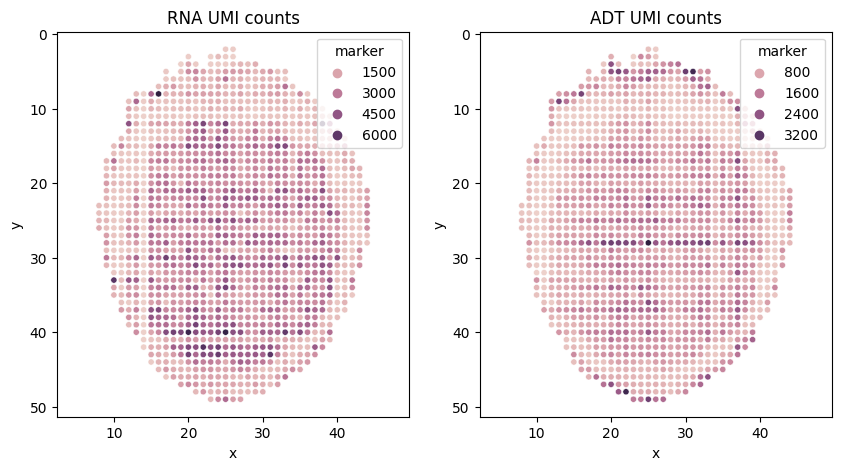

In [6]:
# QC plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_df = spatial.copy()
plot_df["marker"] = rna.sum(axis=1)
sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[0], s=20)
axs[0].axis('equal')
axs[0].invert_yaxis()
axs[0].set_title("RNA UMI counts")

plot_df = spatial.copy()
plot_df["marker"] = prot_orig.sum(axis=1)
sns.scatterplot(x='x', y='y', hue='marker', data=plot_df, ax=axs[1], s=20)
axs[1].axis('equal')
axs[1].invert_yaxis()
axs[1].set_title("ADT UMI counts")
plt.show()

In [7]:
# remove spike ins from rna
print(rna.shape)
spike_bool = np.array(["ERCC" in c for c in rna.columns])
print(spike_bool.sum())
rna = rna.loc[:,~spike_bool]
print(rna.shape)

# remove unmapped from protein
print(prot.shape)
unmapped_bool = np.array(["unmapped" in c for c in prot.columns])
print(unmapped_bool.sum())
prot = prot.loc[:,~unmapped_bool]
print(prot.shape)

(1303, 19923)
0
(1303, 19923)
(1303, 199)
1
(1303, 198)


In [8]:
# TODO: Should we normalize by library size before or after removing spike ins?
# TODO: Should we normalize by library size before or after removing unmapped?
# divide each spot by library size
rna = rna.div(rna.sum(axis=1), axis=0) * 10_000
prot = prot.div(prot.sum(axis=1), axis=0) * 10_000

9999.99999999998
9999.999999999485


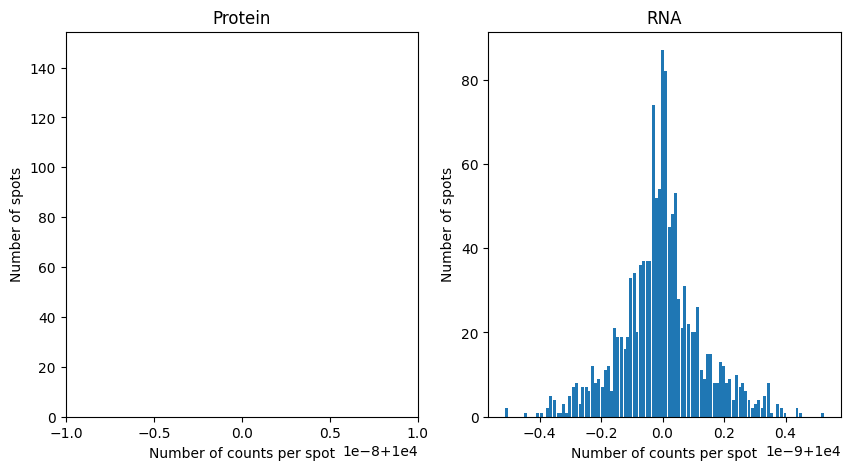

In [9]:
# check the number of counts per spot
print(prot.sum(axis=1).min())
print(rna.sum(axis=1).min())

# plot the histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(prot.sum(axis=1), bins=100)
ax[0].set_xlabel('Number of counts per spot')
ax[0].set_ylabel('Number of spots')
ax[0].set_title('Protein')
ax[1].hist(rna.sum(axis=1), bins=100)
ax[1].set_xlabel('Number of counts per spot')
ax[1].set_ylabel('Number of spots')
ax[1].set_title('RNA')
plt.show()

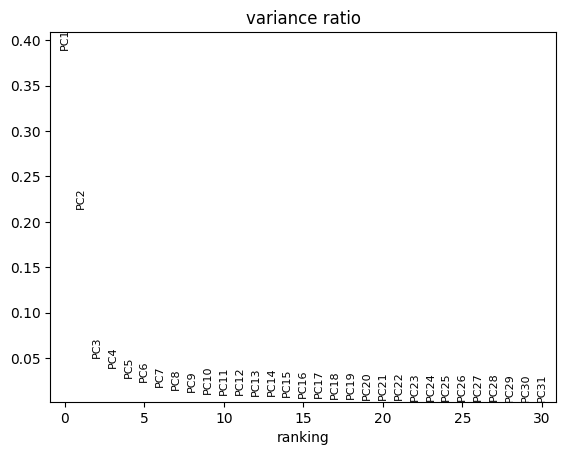

In [10]:
prot_ad = sc.AnnData(X=prot.values, obs=prot.index.to_frame(name="id"), var=prot.columns.to_frame(name="protein"), obsm={"spatial": spatial})
sc.tl.pca(prot_ad, svd_solver='arpack')
sc.pl.pca_variance_ratio(prot_ad)
sc.pp.neighbors(prot_ad, n_neighbors=10, n_pcs=20)
sc.tl.leiden(prot_ad, resolution=0.4)

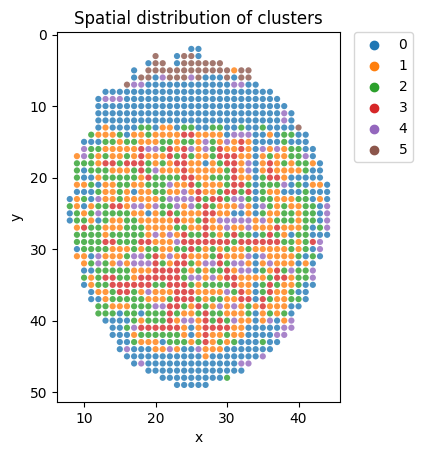

In [11]:
plot_df = prot_ad.obsm["spatial"].copy()
plot_df["marker"] = prot_ad.obs["leiden"].values
# make scatter plot using seaborn
sns.scatterplot(
    data=plot_df,
    x="x",
    y="y",
    hue="marker",
    linewidth=0,
    s=20,
    alpha=0.8,
)
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Spatial distribution of clusters")
plt.show()

4449


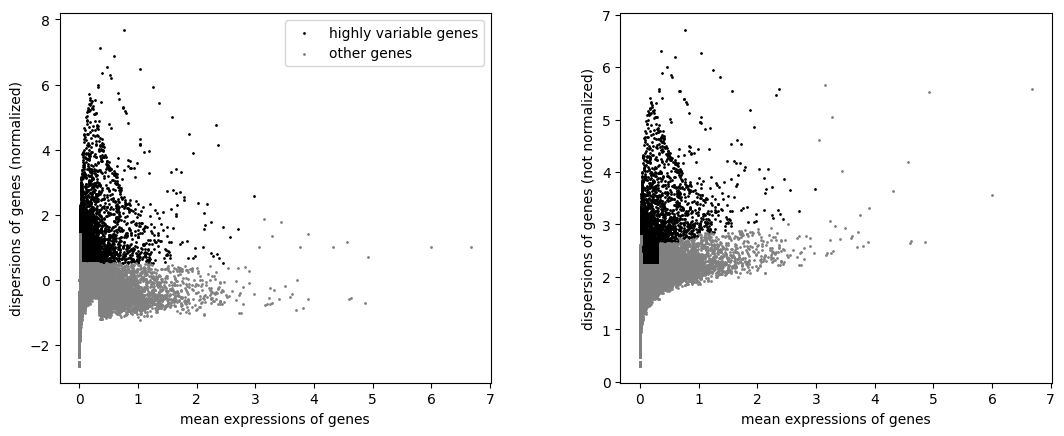

/Users/pschafer/miniconda3/envs/misty_liana/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.


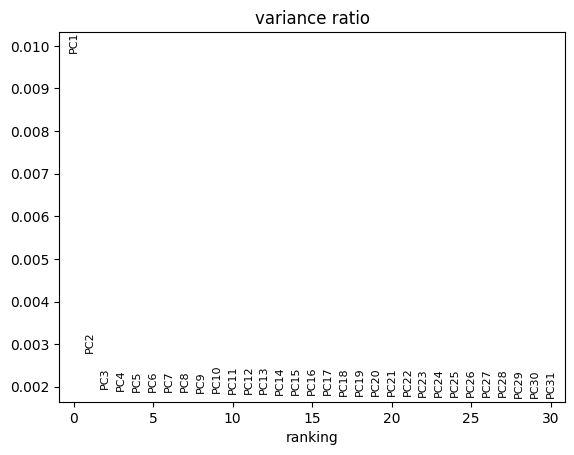

In [12]:
rna_ad = sc.AnnData(X=rna.values, obs=rna.index.to_frame(name="id"), var=rna.columns.to_frame(name="gene"), obsm={"spatial": spatial})
sc.pp.normalize_total(rna_ad, target_sum=1e4)
sc.pp.log1p(rna_ad)
sc.pp.highly_variable_genes(rna_ad, min_mean=0.0125, max_mean=3, min_disp=0.5)
print(rna_ad.var.highly_variable.sum())
sc.pl.highly_variable_genes(rna_ad)
rna_ad = rna_ad[:, rna_ad.var.highly_variable]
sc.pp.scale(rna_ad, max_value=10)
sc.tl.pca(rna_ad, svd_solver='arpack')
sc.pl.pca_variance_ratio(rna_ad)
sc.pp.neighbors(rna_ad, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna_ad, resolution=0.8)

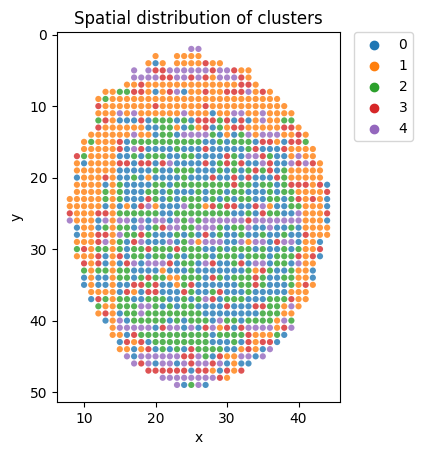

In [13]:
plot_df = rna_ad.obsm["spatial"].copy()
plot_df["marker"] = rna_ad.obs["leiden"].values
# make scatter plot using seaborn
sns.scatterplot(
    data=plot_df,
    x="x",
    y="y",
    hue="marker",
    linewidth=0,
    s=20,
    alpha=0.8,
)
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.title("Spatial distribution of clusters")
plt.show()